# Final Project - Dog Classification

### Dataset
We're using the Stanford Dogs Dataset, which consists of 120 different dog breeds and 20,580 total breeds. First, download the `Images` and `Lists` from this url: http://vision.stanford.edu/aditya86/ImageNetDogs/ and place them into a folder called `stanford-dogs-dataset` in your local directory. Make sure the `stanford-dogs-dataset` has the `Images`, `test_list.mat`, and `train_list.mat` by the end of this. 

Then run the following code to set up the folder structure.

In [6]:
import os
import shutil
import scipy.io
from tqdm import tqdm

root_dir = 'stanford-dogs-dataset'
images_dir = os.path.join(root_dir, 'Images')
train_mat = scipy.io.loadmat(os.path.join(root_dir, 'train_list.mat'))
test_mat = scipy.io.loadmat(os.path.join(root_dir, 'test_list.mat'))

output_train_dir = os.path.join(root_dir, 'train')
output_test_dir = os.path.join(root_dir, 'val')

def organize_data(mat_data, output_dir):
    file_list = mat_data['file_list']
    labels = mat_data['labels'].squeeze()

    for idx in tqdm(range(file_list.shape[0]), desc=f"Processing {output_dir}"):
        relative_path = file_list[idx][0][0]
        class_name = relative_path.split('/')[0]

        class_folder = os.path.join(output_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)
        src = os.path.join(images_dir, relative_path)
        dst = os.path.join(class_folder, os.path.basename(relative_path))
        shutil.move(src, dst)

organize_data(train_mat, output_train_dir)
organize_data(test_mat, output_test_dir)

Processing stanford-dogs-dataset/train:   0%|          | 0/12000 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'stanford-dogs-dataset/Images/n02085620-Chihuahua/n02085620_5927.jpg'

### Model 1

In [51]:
# creating datasets and dataloaders
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGE_SIZE = 128
BATCH_SIZE = 32

# mean = [0.485, 0.456, 0.406]
# std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    # transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std),
])
# datasets
train_dataset = datasets.ImageFolder(root='stanford-dogs-dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='stanford-dogs-dataset/val', transform=val_transforms)
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

class_names = train_dataset.classes
print(class_names)
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Val Dataset Length: {len(val_dataset)}")

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

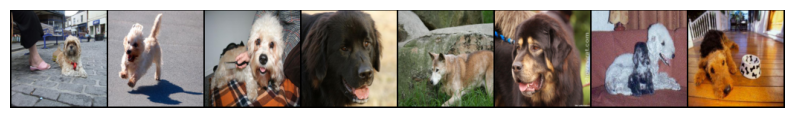

Integer Labels: [4, 43, 43, 104, 117, 93, 30, 38]
Class Names: ['n02086240-Shih-Tzu', 'n02096437-Dandie_Dinmont', 'n02096437-Dandie_Dinmont', 'n02111277-Newfoundland', 'n02115641-dingo', 'n02108551-Tibetan_mastiff', 'n02093647-Bedlington_terrier', 'n02095570-Lakeland_terrier']


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Function to unnormalize and plot a few images
def imshow(img, title=None):
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # show first 8 images
print("Integer Labels:", labels[:8].tolist())
print("Class Names:", [class_names[i] for i in labels[:8]])

In [53]:
import torch.nn as nn

# model
class DogModel(nn.Module):
    def __init__(self):
        super(DogModel, self).__init__()
        
        self.conv_block = nn.Sequential(
            # 128 x 128, 3 channels
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # 128 x 128, 32 channels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 64 x 64, 32 channels

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 32 x 32, 64 channels
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 16 x 16, 128 channels

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 8 x 8, 256 channels
        )

        self.fc_block = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(512, 120)  # 120 dog breeds
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_block(x)
        return x

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("mps" if torch.mps.is_available() else "cpu")

def train(model, train_loader, val_loader, epochs=10, learning_rate=0.0005):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [11]:
model = DogModel().to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, val_loader, epochs=20)

Epoch 1/20 [Val]: 100%|██████████| 269/269 [00:32<00:00,  8.18it/s]


Epoch 1/20 Summary:
Train Loss: 4.7196 | Train Acc: 1.96%
Val   Loss: 4.4251 | Val   Acc: 3.85%


Epoch 2/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.68it/s]


Epoch 2/20 Summary:
Train Loss: 4.3474 | Train Acc: 3.52%
Val   Loss: 4.3132 | Val   Acc: 3.95%


Epoch 3/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.67it/s]


Epoch 3/20 Summary:
Train Loss: 4.1879 | Train Acc: 5.15%
Val   Loss: 4.2221 | Val   Acc: 4.81%


Epoch 4/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.67it/s]


Epoch 4/20 Summary:
Train Loss: 4.0753 | Train Acc: 6.54%
Val   Loss: 4.0941 | Val   Acc: 6.66%


Epoch 5/20 [Val]: 100%|██████████| 269/269 [00:32<00:00,  8.17it/s]


Epoch 5/20 Summary:
Train Loss: 3.9762 | Train Acc: 8.15%
Val   Loss: 4.0733 | Val   Acc: 7.13%


Epoch 6/20 [Val]: 100%|██████████| 269/269 [00:32<00:00,  8.40it/s]


Epoch 6/20 Summary:
Train Loss: 3.8807 | Train Acc: 8.97%
Val   Loss: 3.9796 | Val   Acc: 8.03%


Epoch 7/20 [Val]: 100%|██████████| 269/269 [00:38<00:00,  7.02it/s]


Epoch 7/20 Summary:
Train Loss: 3.7923 | Train Acc: 10.39%
Val   Loss: 4.1667 | Val   Acc: 6.96%


Epoch 8/20 [Val]: 100%|██████████| 269/269 [00:32<00:00,  8.36it/s]


Epoch 8/20 Summary:
Train Loss: 3.7069 | Train Acc: 11.48%
Val   Loss: 4.4886 | Val   Acc: 6.60%


Epoch 9/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.57it/s]


Epoch 9/20 Summary:
Train Loss: 3.6195 | Train Acc: 12.43%
Val   Loss: 3.8504 | Val   Acc: 10.22%


Epoch 10/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.50it/s]


Epoch 10/20 Summary:
Train Loss: 3.5379 | Train Acc: 14.15%
Val   Loss: 4.0801 | Val   Acc: 7.75%


Epoch 11/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.62it/s]


Epoch 11/20 Summary:
Train Loss: 3.4574 | Train Acc: 15.35%
Val   Loss: 3.8644 | Val   Acc: 10.68%


Epoch 12/20 [Val]: 100%|██████████| 269/269 [00:32<00:00,  8.34it/s]


Epoch 12/20 Summary:
Train Loss: 3.3932 | Train Acc: 16.21%
Val   Loss: 3.6671 | Val   Acc: 12.96%


Epoch 13/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.57it/s]


Epoch 13/20 Summary:
Train Loss: 3.3044 | Train Acc: 17.93%
Val   Loss: 3.8196 | Val   Acc: 11.86%


Epoch 14/20 [Val]: 100%|██████████| 269/269 [00:32<00:00,  8.28it/s]


Epoch 14/20 Summary:
Train Loss: 3.2422 | Train Acc: 18.58%
Val   Loss: 3.5419 | Val   Acc: 14.23%


Epoch 15/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.43it/s]


Epoch 15/20 Summary:
Train Loss: 3.1592 | Train Acc: 19.93%
Val   Loss: 3.6899 | Val   Acc: 11.46%


Epoch 16/20 [Val]: 100%|██████████| 269/269 [00:34<00:00,  7.78it/s]


Epoch 16/20 Summary:
Train Loss: 3.0875 | Train Acc: 21.50%
Val   Loss: 3.6415 | Val   Acc: 14.23%


Epoch 17/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.50it/s]


Epoch 17/20 Summary:
Train Loss: 2.9954 | Train Acc: 23.25%
Val   Loss: 3.5005 | Val   Acc: 15.34%


Epoch 18/20 [Val]: 100%|██████████| 269/269 [00:35<00:00,  7.64it/s]


Epoch 18/20 Summary:
Train Loss: 2.9383 | Train Acc: 23.87%
Val   Loss: 3.8318 | Val   Acc: 13.45%


Epoch 19/20 [Val]: 100%|██████████| 269/269 [00:32<00:00,  8.21it/s]


Epoch 19/20 Summary:
Train Loss: 2.8489 | Train Acc: 25.84%
Val   Loss: 3.6566 | Val   Acc: 15.44%


Epoch 20/20 [Val]: 100%|██████████| 269/269 [00:31<00:00,  8.50it/s]

Epoch 20/20 Summary:
Train Loss: 2.7825 | Train Acc: 26.98%
Val   Loss: 4.1356 | Val   Acc: 11.96%


In [12]:
import matplotlib.pyplot as plt
import os

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, save_dir="./results"):
    os.makedirs(save_dir, exist_ok=True)

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Val Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, "loss_curve.png"))
    plt.close()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(val_accuracies, label="Val Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, "accuracy_curve.png"))
    plt.close()

    print(f"✅ Saved loss and accuracy curves to {save_dir}/")

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

✅ Saved loss and accuracy curves to ./results/


In [13]:
def test(model, data_loader):
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    return accuracy, all_preds, all_labels


In [14]:
# Run on the val_loader or test_loader
accuracy, all_preds, all_labels = test(model, val_loader)

Testing: 100%|██████████| 269/269 [00:31<00:00,  8.61it/s]

Test Accuracy: 11.96%


In [55]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.0, 0.0, 0.0])  # No normalization to reverse in your transform
    std = np.array([1.0, 1.0, 1.0])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def visualize_predictions(model, data_loader, class_names, num_images=8):
    model.eval()
    model.to(device)

    images_so_far = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images // 4 + 1, 4, images_so_far)
                imshow(inputs.cpu().data[j], title=f"Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}")


### Model 2

In [17]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
import numpy as np
import random

IMAGE_SIZE = 128
BATCH_SIZE = 32
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Step 1: Load dataset to count samples per class
base_dataset = datasets.ImageFolder(root='stanford-dogs-dataset/train')
class_counts = defaultdict(int)
for _, class_idx in base_dataset.samples:
    class_counts[class_idx] += 1

# Step 2: Get top 10 class indices
top_10_classes = set(sorted(class_counts, key=class_counts.get, reverse=True)[:10])

# Step 3: Filter for top 10 classes and collect all valid indices
all_indices = [i for i, (_, class_idx) in enumerate(base_dataset.samples) if class_idx in top_10_classes]
random.shuffle(all_indices)  # Shuffle before splitting

# Step 4: 80:20 split
split_idx = int(0.8 * len(all_indices))
train_indices = all_indices[:split_idx]
val_indices = all_indices[split_idx:]

# Step 5: Apply transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Step 6: Reload dataset with transforms
full_dataset = datasets.ImageFolder(root='stanford-dogs-dataset/train')
full_dataset.transform = train_transforms
train_dataset = Subset(full_dataset, train_indices)

# Copy and reassign transform for validation
val_dataset = Subset(full_dataset, val_indices)
val_dataset.dataset = datasets.ImageFolder(root='stanford-dogs-dataset/train', transform=val_transforms)

# Step 7: Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Optional: Class names
class_names = [full_dataset.classes[i] for i in top_10_classes]
print("Top 10 Breeds:", class_names)
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Val Dataset Length: {len(val_dataset)}")


Top 10 Breeds: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']
Train Dataset Length: 800
Val Dataset Length: 200


In [18]:
model = DogModel().to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, val_loader, epochs=20)

Epoch 1/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


Epoch 1/20 Summary:
Train Loss: 4.2852 | Train Acc: 14.88%
Val   Loss: 2.4502 | Val   Acc: 20.00%


Epoch 2/20 [Val]: 100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


Epoch 2/20 Summary:
Train Loss: 2.1012 | Train Acc: 26.88%
Val   Loss: 2.1816 | Val   Acc: 23.00%


Epoch 3/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


Epoch 3/20 Summary:
Train Loss: 1.9169 | Train Acc: 32.75%
Val   Loss: 2.2227 | Val   Acc: 25.00%


Epoch 4/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 4/20 Summary:
Train Loss: 1.8229 | Train Acc: 37.25%
Val   Loss: 2.2317 | Val   Acc: 22.00%


Epoch 5/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


Epoch 5/20 Summary:
Train Loss: 1.5647 | Train Acc: 45.38%
Val   Loss: 2.1130 | Val   Acc: 29.50%


Epoch 6/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


Epoch 6/20 Summary:
Train Loss: 1.5462 | Train Acc: 45.12%
Val   Loss: 1.9409 | Val   Acc: 32.00%


Epoch 7/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 7/20 Summary:
Train Loss: 1.3330 | Train Acc: 52.25%
Val   Loss: 1.9777 | Val   Acc: 35.00%


Epoch 8/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


Epoch 8/20 Summary:
Train Loss: 1.1946 | Train Acc: 58.38%
Val   Loss: 1.9979 | Val   Acc: 39.00%


Epoch 9/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


Epoch 9/20 Summary:
Train Loss: 1.0786 | Train Acc: 62.75%
Val   Loss: 2.0084 | Val   Acc: 31.00%


Epoch 10/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.65s/it]


Epoch 10/20 Summary:
Train Loss: 0.9512 | Train Acc: 68.88%
Val   Loss: 2.1054 | Val   Acc: 40.50%


Epoch 11/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 11/20 Summary:
Train Loss: 0.8760 | Train Acc: 69.25%
Val   Loss: 2.1359 | Val   Acc: 37.50%


Epoch 12/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


Epoch 12/20 Summary:
Train Loss: 0.7265 | Train Acc: 75.62%
Val   Loss: 2.1055 | Val   Acc: 40.50%


Epoch 13/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.65s/it]


Epoch 13/20 Summary:
Train Loss: 0.6786 | Train Acc: 77.25%
Val   Loss: 2.1512 | Val   Acc: 36.50%


Epoch 14/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Epoch 14/20 Summary:
Train Loss: 0.6211 | Train Acc: 79.75%
Val   Loss: 2.1812 | Val   Acc: 39.50%


Epoch 15/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Epoch 15/20 Summary:
Train Loss: 0.4636 | Train Acc: 86.62%
Val   Loss: 2.2665 | Val   Acc: 37.00%


Epoch 16/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.60s/it]


Epoch 16/20 Summary:
Train Loss: 0.3786 | Train Acc: 89.00%
Val   Loss: 2.3671 | Val   Acc: 40.50%


Epoch 17/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.65s/it]


Epoch 17/20 Summary:
Train Loss: 0.3747 | Train Acc: 88.38%
Val   Loss: 2.4621 | Val   Acc: 39.50%


Epoch 18/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


Epoch 18/20 Summary:
Train Loss: 0.2592 | Train Acc: 93.00%
Val   Loss: 2.2078 | Val   Acc: 42.50%


Epoch 19/20 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.69s/it]


Epoch 19/20 Summary:
Train Loss: 0.2180 | Train Acc: 94.12%
Val   Loss: 2.2545 | Val   Acc: 39.50%


Epoch 20/20 [Val]: 100%|██████████| 7/7 [00:29<00:00,  4.16s/it]

Epoch 20/20 Summary:
Train Loss: 0.1945 | Train Acc: 95.00%
Val   Loss: 2.4374 | Val   Acc: 45.00%


In [19]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

✅ Saved loss and accuracy curves to ./results/


In [20]:
# Run on the val_loader or test_loader
accuracy, all_preds, all_labels = test(model, val_loader)

Testing: 100%|██████████| 7/7 [00:26<00:00,  3.81s/it]

Test Accuracy: 45.00%


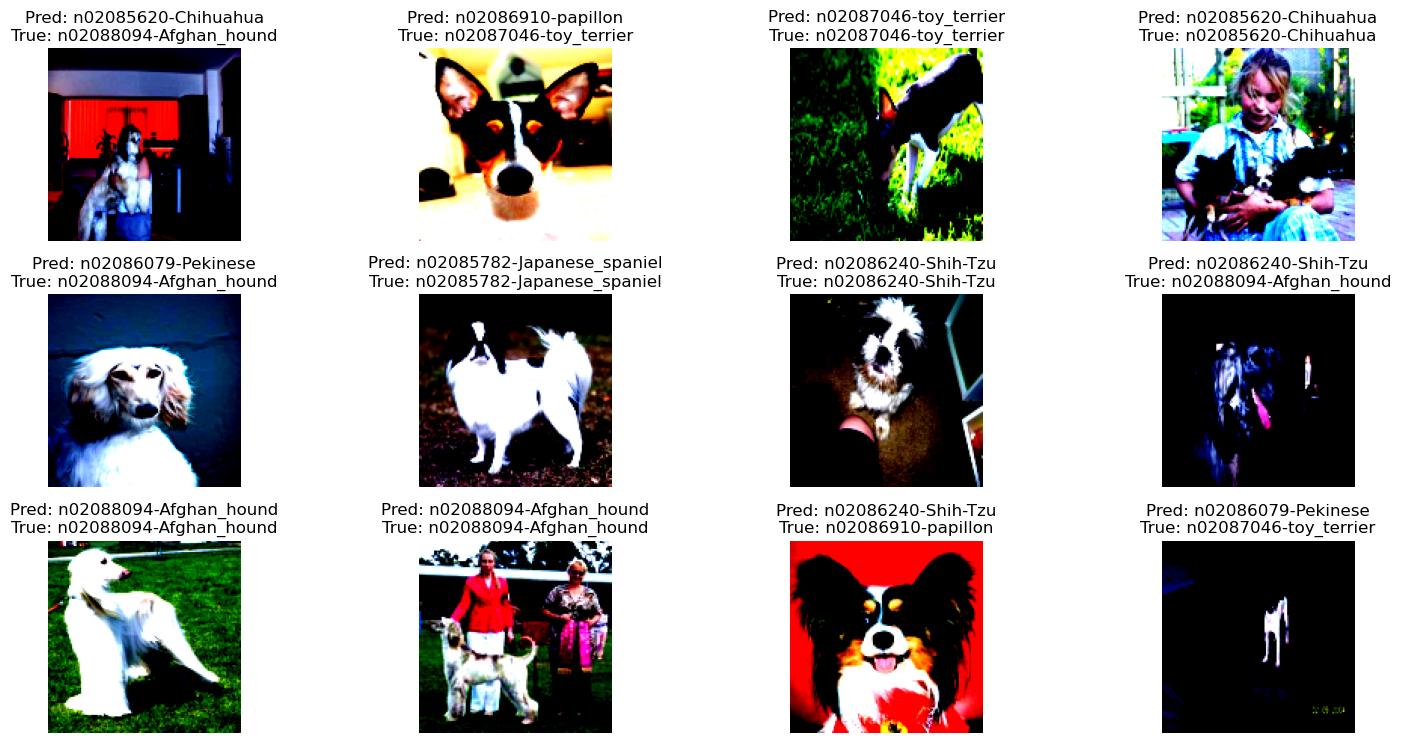

In [21]:
visualize_predictions(model, val_loader, class_names, num_images=12)

### Model 3

In [42]:
# creating datasets and dataloaders
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

IMAGE_SIZE = 128
BATCH_SIZE = 32

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

selected_breeds = [
    'n02085620-Chihuahua',
    'n02109047-Great_Dane',
    'n02113712-miniature_poodle',
    'n02096585-Boston_bull',   
    'n02110185-Siberian_husky',
]

def filter_dataset(dataset):
    class_to_idx = dataset.class_to_idx
    selected_indices = []
    selected_class_indices = [class_to_idx[breed] for breed in selected_breeds if breed in class_to_idx]

    for idx, (img_path, label) in enumerate(dataset.samples):
        if label in selected_class_indices:
            selected_indices.append(idx)

    return Subset(dataset, selected_indices)
    


# datasets
full_train_dataset = datasets.ImageFolder(root='stanford-dogs-dataset/train', transform=train_transforms)
full_val_dataset = datasets.ImageFolder(root='stanford-dogs-dataset/val', transform=val_transforms)
train_dataset = filter_dataset(full_train_dataset)
val_dataset = filter_dataset(full_val_dataset)
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

class_names = [name for name in selected_breeds if name in full_train_dataset.class_to_idx]
print("Class Names:", class_names)
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Val Dataset Length: {len(val_dataset)}")


Class Names: ['n02085620-Chihuahua', 'n02109047-Great_Dane', 'n02113712-miniature_poodle', 'n02096585-Boston_bull', 'n02110185-Siberian_husky']
Train Dataset Length: 500
Val Dataset Length: 337


In [23]:
model = DogModel().to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, val_loader, epochs=15)

Epoch 1/15 [Val]: 100%|██████████| 11/11 [00:28<00:00,  2.55s/it]


Epoch 1/15 Summary:
Train Loss: 4.7796 | Train Acc: 27.40%
Val   Loss: 1.8673 | Val   Acc: 27.89%


Epoch 2/15 [Val]: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it]


Epoch 2/15 Summary:
Train Loss: 1.9639 | Train Acc: 41.00%
Val   Loss: 1.7897 | Val   Acc: 42.14%


Epoch 3/15 [Val]: 100%|██████████| 11/11 [00:25<00:00,  2.32s/it]


Epoch 3/15 Summary:
Train Loss: 1.4670 | Train Acc: 46.80%
Val   Loss: 1.6194 | Val   Acc: 40.95%


Epoch 4/15 [Val]: 100%|██████████| 11/11 [00:26<00:00,  2.41s/it]


Epoch 4/15 Summary:
Train Loss: 1.2333 | Train Acc: 52.20%
Val   Loss: 1.7122 | Val   Acc: 38.87%


Epoch 5/15 [Val]: 100%|██████████| 11/11 [00:29<00:00,  2.67s/it]


Epoch 5/15 Summary:
Train Loss: 1.2573 | Train Acc: 53.40%
Val   Loss: 1.7122 | Val   Acc: 36.80%


Epoch 6/15 [Val]: 100%|██████████| 11/11 [04:10<00:00, 22.77s/it]


Epoch 6/15 Summary:
Train Loss: 1.1503 | Train Acc: 58.00%
Val   Loss: 1.8465 | Val   Acc: 37.69%


Epoch 7/15 [Val]: 100%|██████████| 11/11 [00:56<00:00,  5.12s/it]


Epoch 7/15 Summary:
Train Loss: 0.9904 | Train Acc: 60.80%
Val   Loss: 1.5936 | Val   Acc: 43.32%


Epoch 8/15 [Val]: 100%|██████████| 11/11 [03:19<00:00, 18.18s/it]


Epoch 8/15 Summary:
Train Loss: 0.9662 | Train Acc: 65.60%
Val   Loss: 1.8089 | Val   Acc: 40.65%


Epoch 9/15 [Val]: 100%|██████████| 11/11 [00:25<00:00,  2.32s/it]


Epoch 9/15 Summary:
Train Loss: 0.8806 | Train Acc: 67.80%
Val   Loss: 1.7966 | Val   Acc: 42.73%


Epoch 10/15 [Val]: 100%|██████████| 11/11 [00:27<00:00,  2.50s/it]


Epoch 10/15 Summary:
Train Loss: 0.8421 | Train Acc: 67.60%
Val   Loss: 1.7132 | Val   Acc: 42.14%


Epoch 11/15 [Val]: 100%|██████████| 11/11 [00:25<00:00,  2.34s/it]


Epoch 11/15 Summary:
Train Loss: 0.7536 | Train Acc: 72.60%
Val   Loss: 1.8104 | Val   Acc: 38.28%


Epoch 12/15 [Val]: 100%|██████████| 11/11 [00:25<00:00,  2.32s/it]


Epoch 12/15 Summary:
Train Loss: 0.6233 | Train Acc: 78.60%
Val   Loss: 1.8417 | Val   Acc: 41.25%


Epoch 13/15 [Val]: 100%|██████████| 11/11 [00:25<00:00,  2.31s/it]


Epoch 13/15 Summary:
Train Loss: 0.6012 | Train Acc: 75.20%
Val   Loss: 1.8518 | Val   Acc: 45.10%


Epoch 14/15 [Val]: 100%|██████████| 11/11 [00:25<00:00,  2.33s/it]


Epoch 14/15 Summary:
Train Loss: 0.5229 | Train Acc: 80.00%
Val   Loss: 2.0928 | Val   Acc: 42.43%


Epoch 15/15 [Val]: 100%|██████████| 11/11 [00:25<00:00,  2.32s/it]

Epoch 15/15 Summary:
Train Loss: 0.4830 | Train Acc: 82.40%
Val   Loss: 1.9554 | Val   Acc: 40.06%


In [24]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

✅ Saved loss and accuracy curves to ./results/


In [25]:
# Run on the val_loader or test_loader
accuracy, all_preds, all_labels = test(model, val_loader)

Testing: 100%|██████████| 11/11 [00:25<00:00,  2.35s/it]

Test Accuracy: 40.06%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.0, 0.0, 0.0])  # No normalization to reverse in your transform
    std = np.array([1.0, 1.0, 1.0])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def visualize_predictions(model, data_loader, class_names, num_images=8):
    model.eval()
    model.to(device)

    images_so_far = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images // 4 + 1, 4, images_so_far)
                imshow(inputs.cpu().data[j], title=f"Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}")


<h1> Experiments <h1>

Using Model 2 Dataset:

In [29]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
import numpy as np
import random

IMAGE_SIZE = 128
BATCH_SIZE = 32
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Step 1: Load dataset to count samples per class
base_dataset = datasets.ImageFolder(root='stanford-dogs-dataset/train')
class_counts = defaultdict(int)
for _, class_idx in base_dataset.samples:
    class_counts[class_idx] += 1

# Step 2: Get top 10 class indices
top_10_classes = set(sorted(class_counts, key=class_counts.get, reverse=True)[:10])

# Step 3: Filter for top 10 classes and collect all valid indices
all_indices = [i for i, (_, class_idx) in enumerate(base_dataset.samples) if class_idx in top_10_classes]
random.shuffle(all_indices)  # Shuffle before splitting

# Step 4: 80:20 split
split_idx = int(0.8 * len(all_indices))
train_indices = all_indices[:split_idx]
val_indices = all_indices[split_idx:]

# Step 5: Apply transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Step 6: Reload dataset with transforms
full_dataset = datasets.ImageFolder(root='stanford-dogs-dataset/train')
full_dataset.transform = train_transforms
train_dataset = Subset(full_dataset, train_indices)

# Copy and reassign transform for validation
val_dataset = Subset(full_dataset, val_indices)
val_dataset.dataset = datasets.ImageFolder(root='stanford-dogs-dataset/train', transform=val_transforms)

# Step 7: Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Optional: Class names
class_names = [full_dataset.classes[i] for i in top_10_classes]
print("Top 10 Breeds:", class_names)
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Val Dataset Length: {len(val_dataset)}")


Top 10 Breeds: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']
Train Dataset Length: 800
Val Dataset Length: 200


In [30]:
import torchvision.models as models
import torch
from tqdm import tqdm

resnet50 = models.resnet50(pretrained=True)
resnet50.eval()
resnet50.to(device)

correct_top1 = 0
correct_top5 = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating ResNet-50"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)

        # Top-1
        _, predicted = outputs.topk(1, dim=1)
        correct_top1 += (predicted.squeeze() == labels).sum().item()

        # Top-5
        top5 = outputs.topk(5, dim=1).indices
        for i in range(labels.size(0)):
            if labels[i] in top5[i]:
                correct_top5 += 1

        total += labels.size(0)

print(f"Top-1 Accuracy: {100 * correct_top1 / total:.2f}%")
print(f"Top-5 Accuracy: {100 * correct_top5 / total:.2f}%")


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating ResNet-50: 100%|██████████| 7/7 [00:26<00:00,  3.81s/it]

Top-1 Accuracy: 0.00%
Top-5 Accuracy: 0.00%


<h4> Without Normalization <h4>

In [31]:
# model
class DogModelNoNorm(nn.Module):
    def __init__(self):
        super(DogModelNoNorm, self).__init__()
        
        self.conv_block = nn.Sequential(
            # 128 x 128, 3 channels
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # 128 x 128, 32 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 64 x 64, 32 channels

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 32 x 32, 64 channels
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 16 x 16, 128 channels

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 8 x 8, 256 channels
        )

        self.fc_block = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(512, 120)  # 120 dog breeds
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_block(x)
        return x


In [32]:
model = DogModelNoNorm()
train(model, train_loader, val_loader, epochs=10)

Epoch 1/10 [Val]: 100%|██████████| 7/7 [00:26<00:00,  3.76s/it]


Epoch 1/10 Summary:
Train Loss: 2.8025 | Train Acc: 10.25%
Val   Loss: 2.4293 | Val   Acc: 13.00%


Epoch 2/10 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


Epoch 2/10 Summary:
Train Loss: 2.2610 | Train Acc: 17.50%
Val   Loss: 2.2886 | Val   Acc: 14.00%


Epoch 3/10 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


Epoch 3/10 Summary:
Train Loss: 2.1392 | Train Acc: 21.25%
Val   Loss: 2.0968 | Val   Acc: 23.00%


Epoch 4/10 [Val]: 100%|██████████| 7/7 [00:26<00:00,  3.73s/it]


Epoch 4/10 Summary:
Train Loss: 2.0389 | Train Acc: 25.88%
Val   Loss: 2.0587 | Val   Acc: 27.00%


Epoch 5/10 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.59s/it]


Epoch 5/10 Summary:
Train Loss: 1.8969 | Train Acc: 33.88%
Val   Loss: 2.1553 | Val   Acc: 26.50%


Epoch 6/10 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 6/10 Summary:
Train Loss: 1.7712 | Train Acc: 37.75%
Val   Loss: 1.9424 | Val   Acc: 30.00%


Epoch 7/10 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 7/10 Summary:
Train Loss: 1.6007 | Train Acc: 45.25%
Val   Loss: 2.0257 | Val   Acc: 32.50%


Epoch 8/10 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Epoch 8/10 Summary:
Train Loss: 1.4316 | Train Acc: 51.38%
Val   Loss: 2.0856 | Val   Acc: 32.50%


Epoch 9/10 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


Epoch 9/10 Summary:
Train Loss: 1.2556 | Train Acc: 58.00%
Val   Loss: 2.0152 | Val   Acc: 37.00%


Epoch 10/10 [Val]: 100%|██████████| 7/7 [00:25<00:00,  3.67s/it]

Epoch 10/10 Summary:
Train Loss: 1.1211 | Train Acc: 62.00%
Val   Loss: 2.0151 | Val   Acc: 36.00%


([2.8025039768218996,
  2.261032180786133,
  2.1392097330093383,
  2.038858118057251,
  1.8969286680221558,
  1.7711501407623291,
  1.6006662702560426,
  1.43157386302948,
  1.2556267476081848,
  1.1211492490768433],
 [10.25, 17.5, 21.25, 25.875, 33.875, 37.75, 45.25, 51.375, 58.0, 62.0],
 [2.4293260765075684,
  2.288580684661865,
  2.0968127155303957,
  2.058699817657471,
  2.15531623840332,
  1.9424159526824951,
  2.0256721210479736,
  2.0856386613845825,
  2.015209093093872,
  2.015092945098877],
 [13.0, 14.0, 23.0, 27.0, 26.5, 30.0, 32.5, 32.5, 37.0, 36.0])

Testing: 100%|██████████| 7/7 [00:25<00:00,  3.70s/it]

Test Accuracy: 36.00%


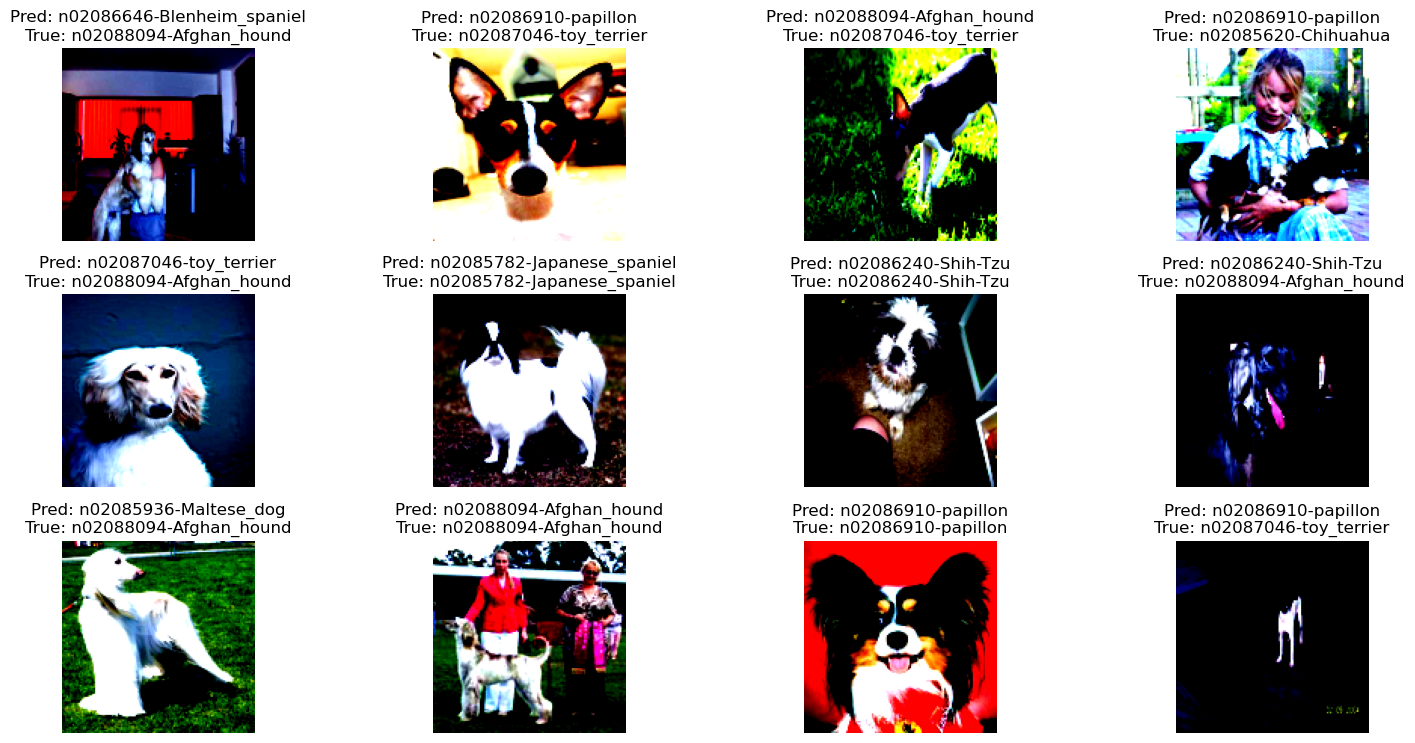

In [33]:
test(model, val_loader)
visualize_predictions(model, val_loader, class_names, num_images=12)

=== Cartoon Image Predictions ===
Papillon.png → Predicted: n02086910-papillon
Blenheim-spaniel.png → Predicted: n02086910-papillon
toy-terrier.png → Predicted: n02086240-Shih-Tzu
Chihuahua.png → Predicted: n02086079-Pekinese
Shih-tzu.png → Predicted: n02086079-Pekinese
afghan-hound.png → Predicted: n02086079-Pekinese
Pekinese.png → Predicted: n02086079-Pekinese
rhodesian-ridgeback.png → Predicted: n02086079-Pekinese
Maltese.png → Predicted: n02086079-Pekinese
Japanese-spaniel.png → Predicted: n02086910-papillon


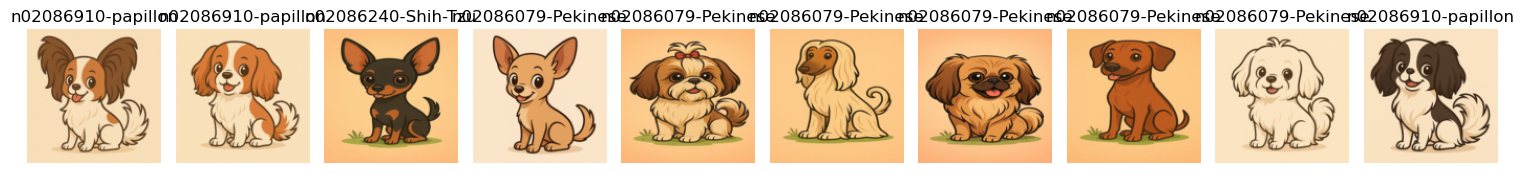

In [34]:
from PIL import Image
import torchvision.transforms as transforms
import os
import torch
import matplotlib.pyplot as plt

# Folder containing your cartoon images
CARTOON_DIR = 'cartoon-dogs'

# Transformation should match your val_transform (normalization is crucial!)
ood_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

def load_cartoon_images(folder_path, transform):
    images = []
    image_names = []
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, file)
            image = Image.open(img_path).convert('RGB')
            images.append(transform(image))
            image_names.append(file)
    return torch.stack(images), image_names

# Load and prepare cartoon images
cartoon_images, image_names = load_cartoon_images(CARTOON_DIR, ood_transform)
cartoon_images = cartoon_images.to(device)

# Set model to evaluation
model.eval()

with torch.no_grad():
    outputs = model(cartoon_images)
    _, predicted = torch.max(outputs, 1)

# Print results
print("=== Cartoon Image Predictions ===")
for filename, pred_idx in zip(image_names, predicted.cpu().numpy()):
    print(f"{filename} → Predicted: {class_names[pred_idx]}")

# Optionally visualize
def visualize_predictions(images_tensor, preds, names, classes, max_imgs=10):
    plt.figure(figsize=(15, 5))
    for i in range(min(max_imgs, len(images_tensor))):
        img = images_tensor[i].cpu().permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)
        img = torch.clamp(img, 0, 1)
        plt.subplot(1, max_imgs, i + 1)
        plt.imshow(img)
        plt.title(classes[preds[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(cartoon_images, predicted.cpu().numpy(), image_names, class_names)



Hence, we got a 30% accuracy on cartoon dog images on the model with the 10 most frequent images.

RESNET EXPERIMENT:

In [35]:
from torchvision import models
import torch.nn.functional as F

# Ensure same device as before
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Map your top 10 class names to their ImageNet indices
target_classes = {
    "n02085620-Chihuahua": 151,
    "n02085782-Japanese_spaniel": 152,
    "n02085936-Maltese_dog": 153,
    "n02086079-Pekinese": 154,
    "n02086240-Shih-Tzu": 155,
    "n02086646-Blenheim_spaniel": 156,
    "n02086910-papillon": 157,
    "n02087046-toy_terrier": 158,
    "n02087394-Rhodesian_ridgeback": 159,
    "n02088094-Afghan_hound": 160,
}


# Load pretrained ResNet
model = models.resnet50(pretrained=True)
model.eval().to(device)

correct = 0
total = 0

# Map classes indices
mapping_dict = {
    i: target_classes[class_names[i]] for i in range(len(class_names))
}

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = transforms.functional.resize(inputs, [224, 224])
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        for i in range(inputs.size(0)):
            imagenet_index = mapping_dict[labels[i].item()]
            if preds[i].item() == imagenet_index:
                correct += 1
            total += 1

print(f"\nAccuracy: {correct}/{total} = {correct / total:.2%}")



Accuracy: 171/200 = 85.50%
